<a href="https://colab.research.google.com/github/AgainstEntropy/ECE-GY-7123-DL-Assignments/blob/main/notebooks/demo01_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Basics

I'll assume that everyone is familiar with python. Training neural nets in bare python is somewhat painful, but fortunately there are several well-established libraries which can help. I like pytorch, which is built upon an earlier library called torch. There are many others, including TensorFlow and Jax.

In [1]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torchvision

In [ ]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.64520577 0.01220981 0.41715171]
 [0.85467564 0.13222973 0.02282506]]
tensor([[0.6452, 0.0122, 0.4172],
        [0.8547, 0.1322, 0.0228]], dtype=torch.float64)


In [ ]:
print(b + 10.0)
print()
print(torch.sin(b))
print()
print(b.sum())
print()
print(b.mean())
print()
print(b.shape)

tensor([[10.6452, 10.0122, 10.4172],
        [10.8547, 10.1322, 10.0228]], dtype=torch.float64)

tensor([[0.6014, 0.0122, 0.4052],
        [0.7544, 0.1318, 0.0228]], dtype=torch.float64)

tensor(2.0843, dtype=torch.float64)

tensor(0.3474, dtype=torch.float64)

torch.Size([2, 3])


Torch believes everything is a *tensor.*

The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon, we will see that training neural nets basically consits of *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about torch variables is that they (natively) can be differentiated. Again, we'll see why this is important when we learn about backpropagation.

Suppose we want $dy/da$ in the following expression:
- $y = a + b$

In [ ]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = a + b
print("a:", a)
print("b:", b)
print("y:", y)

a: tensor([[0.7080]], requires_grad=True)
b: tensor([[0.6772]])
y: tensor([[1.3852]], grad_fn=<AddBackward0>)


Here, $y$ is a function of the input $a$ so we can use PyTorch to compute $dy/da$

In [ ]:
y.backward()
print("dy/da:", a.grad)

dy/da: tensor([[1.]])


Let's try this again with a more complex function:
- $y = a^2 \cdot b$



In [ ]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = (a**2)*b
print("a:", a)
print("b:", b)
print("y:", y)
y.backward()
print("dy/da:", a.grad)
print("dy/da:", 2 * a * b)

a: tensor([[0.3736]], requires_grad=True)
b: tensor([[0.6874]])
y: tensor([[0.0959]], grad_fn=<MulBackward0>)
dy/da: tensor([[0.5136]])
dy/da: tensor([[0.5136]], grad_fn=<MulBackward0>)


Torch has calculated $dy/da$ using backpropagation which is in agreement with our answer calculated using standard differentiation rules.

Here is an example with matrices and vectors:

In [ ]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad = True)

y = torch.matmul(A, x) + b
z = y.sum()

Here, $z$ is a function of the input $x$. Let us now compute the derivative of $z$ with respect to $x$ using backpropagation.

In [ ]:
z.backward()
print(x)
print(x.grad)

tensor([[0.4825],
        [0.4194]], requires_grad=True)
tensor([[0.7919],
        [0.5815]])


## Training simple models

Let's jump in with our first, simple model. We will train a logistic classifier (equivalent to using a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. Torchvision also has several other image datasets which we can directly load as variables.

In [2]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 14749460.24it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271646.21it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4917811.75it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5949924.77it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Let's check that everything has been downloaded.

In [3]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Let's investigate to see what's inside the dataset.

In [4]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the image object given that its first dimension has a size of 1. So we will use the `squeeze` function to get rid of the first dimension.

In [5]:
print(image.squeeze().shape)

torch.Size([28, 28])


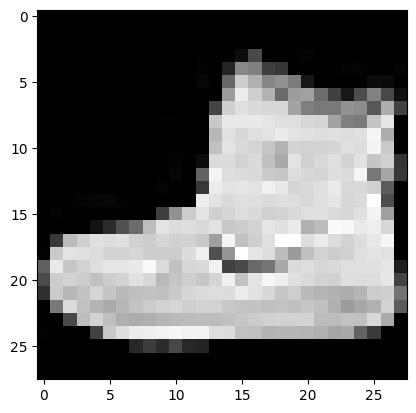

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze(), cmap=plt.cm.gray)

Looks like a shoe? Fashion-MNIST is a bunch of different black and white images of clothing with a corresponding label identifying the category the clothing belongs to. It looks like label 9 corresponds to shoes.

In order to nicely wrap the process of iterating through the dataset, we'll use a dataloader.

In [7]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64, shuffle=False)

Let's also check the length of the train and test dataloader

In [8]:
print(len(trainDataLoader))
print(len(testDataLoader))

938
157


The length here depends upon the batch size defined above. Multiplying the length of our dataloader by the batch size should give us back the number of samples in each set.

In [9]:
print(len(trainDataLoader) * 64) # batch_size from above
print(len(testDataLoader) * 64)

60032
10048


Now let's use it to look at a few images.

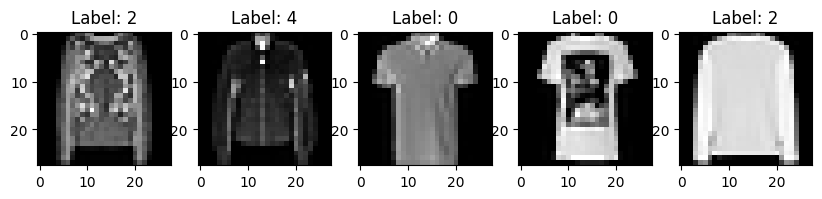

In [10]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

Now let's set up our model.

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28, 10)

  def forward(self, x):
    x = x.view(-1, 28*28) # change so 784 vector instead of 28x28 matrix
    return self.linear(x)

model = LinearReg().cuda() # Step 1: architecture
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Step 3: training method

Now let's train our model!

In [ ]:
train_loss_history = []
test_loss_history = []
for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  model.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 0.9553620932834235, Test loss 0.736996688470719
Epoch 1, Train loss 0.6668659853401468, Test loss 0.6464019060894183
Epoch 2, Train loss 0.6032069566915793, Test loss 0.6028844742638291
Epoch 3, Train loss 0.5686335780028341, Test loss 0.5781896467421465
Epoch 4, Train loss 0.5458437362904234, Test loss 0.5596165345732573
Epoch 5, Train loss 0.5293176235484162, Test loss 0.5492533321972866
Epoch 6, Train loss 0.5165636479092051, Test loss 0.5375335216522217
Epoch 7, Train loss 0.5062508906192108, Test loss 0.5305329223347318
Epoch 8, Train loss 0.49812534781915546, Test loss 0.5221894180319112
Epoch 9, Train loss 0.49097419113937474, Test loss 0.5148341868333756
Epoch 10, Train loss 0.48468940473123906, Test loss 0.5102280188517966
Epoch 11, Train loss 0.4794148547308786, Test loss 0.5056251080552484
Epoch 12, Train loss 0.4747526313958646, Test loss 0.503858678469992
Epoch 13, Train loss 0.47058032103565967, Test loss 0.4974184581048929
Epoch 14, Train loss 0.46666

Let's plot our loss by training epoch to see how we did.

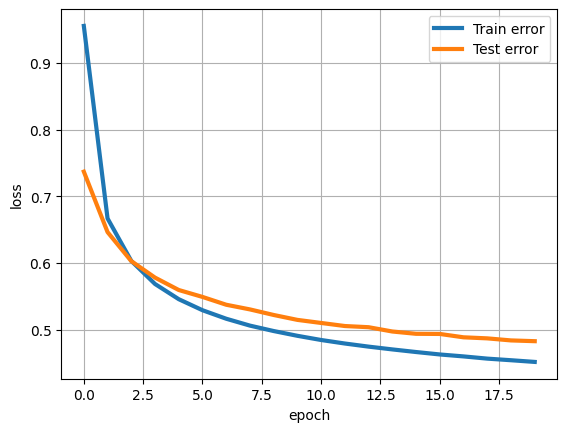

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

Why is test loss larger than training loss?

We definitely see some improvement. Let's look at the images, the predictions our model makes and the true label.

Now for the labels and predicted labels.

In [ ]:
predicted_outputs = model(images)
predicted_classes = torch.max(predicted_outputs, 1)[1]
print('Predicted:', predicted_classes)
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())

Predicted: tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
0.3088383376598358


Text(0.5, 1.0, 'Pred: 1, True: 2')

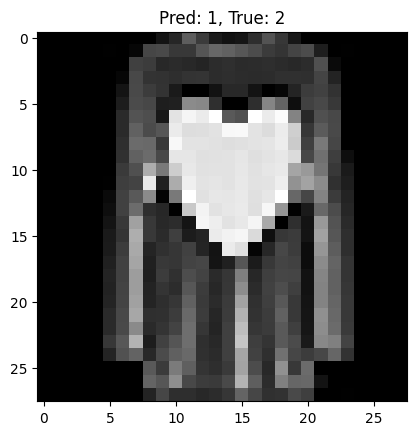

In [ ]:
plt.imshow(images[1].squeeze().cpu(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[1].item()}, True: {labels[1].item()}')

## Train dense nueral network

In [11]:
import torch.nn as nn

class Dense(nn.Module):
    def __init__(self,
                 dims: list[int],
                 sample_size: int = 28*28,
                 num_classes: int = 10):
        super().__init__()

        self.layers = nn.ModuleList()
        dims = [sample_size, *dims, num_classes]
        for i in range(-len(dims), -1):
            self.layers.append(nn.Sequential(
                    nn.Linear(dims[i], dims[i+1]),
                    nn.ReLU(inplace=True) if i < -2 else nn.Identity(),
                )
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(1)
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
torch.manual_seed(425)

dense_model = Dense([256, 128, 64])
dense_model = dense_model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dense_model.parameters(), lr=0.01)

In [14]:
from tqdm.auto import tqdm

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(20):

    train_progress_bar = tqdm(
        range(0, len(trainDataLoader)),
        initial=0,
        desc="Train Steps",
    )

    dense_model.train()
    train_loss = 0.0
    train_correct_num = 0
    for i, (images, labels) in enumerate(trainDataLoader):
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad() # zero out any gradient values from the previous iteration
        predicted_output = dense_model(images) # forward propagation
        loss = criterion(predicted_output, labels)  # calculate our measure of goodness
        loss.backward() # backpropagation
        optimizer.step() # update the weights of our trainable parameters
        train_loss += loss.item()

        train_correct_num += torch.sum(predicted_output.argmax(-1) == labels).item()

        train_progress_bar.update(1)
        train_progress_bar.set_postfix({"train step loss": loss.item()})

    train_loss = train_loss / len(trainDataLoader)
    train_loss_history += [train_loss]
    train_acc = train_correct_num / len(trainDataLoader.dataset)
    train_accuracy_history.append(train_acc)

    test_progress_bar = tqdm(
        range(0, len(testDataLoader)),
        initial=0,
        desc="Test Steps",
    )

    dense_model.eval()
    test_loss = 0.0
    test_correct_num = 0
    for i, (images, labels) in enumerate(testDataLoader):
        with torch.no_grad():
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = dense_model(images)
            loss = criterion(predicted_output, labels)
            test_loss += loss.item()

            test_correct_num += torch.sum(predicted_output.argmax(-1) == labels).item()

        test_progress_bar.update(1)

    test_loss = test_loss / len(testDataLoader)
    test_loss_history += [test_loss]
    test_acc = test_correct_num / len(testDataLoader.dataset)
    test_accuracy_history.append(test_acc)

    print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}, Train Acc. {train_acc}, Test Acc. {test_acc}')

Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0, Train loss 1.8416313849913795, Test loss 1.0965482129412851, Train Acc. 0.3018, Test Acc. 0.5903


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1, Train loss 0.8576343839864995, Test loss 0.7772682457213189, Train Acc. 0.6793, Test Acc. 0.7115


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2, Train loss 0.671775816473117, Test loss 0.6631217333161907, Train Acc. 0.7560166666666667, Test Acc. 0.7582


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3, Train loss 0.5929652426415669, Test loss 0.5809322654441663, Train Acc. 0.7895166666666666, Test Acc. 0.7965


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Train loss 0.5446035639245881, Test loss 0.5645285051339751, Train Acc. 0.8104333333333333, Test Acc. 0.8034


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Train loss 0.5132585312130609, Test loss 0.522987732462063, Train Acc. 0.8200333333333333, Test Acc. 0.817


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6, Train loss 0.48944132258770057, Test loss 0.5112965471425633, Train Acc. 0.8286333333333333, Test Acc. 0.8209


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7, Train loss 0.47002778202295303, Test loss 0.496742022644942, Train Acc. 0.8345833333333333, Test Acc. 0.8193


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8, Train loss 0.45402078319396544, Test loss 0.47503889252425757, Train Acc. 0.8410166666666666, Test Acc. 0.8334


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9, Train loss 0.43697441200902465, Test loss 0.47084557744348127, Train Acc. 0.8458, Test Acc. 0.8335


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10, Train loss 0.42424736227562176, Test loss 0.47131353246558244, Train Acc. 0.8517166666666667, Test Acc. 0.833


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11, Train loss 0.41279692115432925, Test loss 0.4326678016193353, Train Acc. 0.8549, Test Acc. 0.8478


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12, Train loss 0.40125012550272665, Test loss 0.42963317786432376, Train Acc. 0.8597, Test Acc. 0.8516


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13, Train loss 0.3916008177755484, Test loss 0.48103811663047524, Train Acc. 0.862, Test Acc. 0.8339


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14, Train loss 0.38294769480411434, Test loss 0.46755720807868206, Train Acc. 0.8649, Test Acc. 0.8302


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15, Train loss 0.3740763922553581, Test loss 0.4224078107601518, Train Acc. 0.8690333333333333, Test Acc. 0.8519


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16, Train loss 0.3667911843958694, Test loss 0.438665366096861, Train Acc. 0.8706666666666667, Test Acc. 0.8436


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17, Train loss 0.35998888532998463, Test loss 0.48533511000454044, Train Acc. 0.8731166666666667, Test Acc. 0.8192


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18, Train loss 0.35232542294746777, Test loss 0.3972123886939067, Train Acc. 0.8746, Test Acc. 0.8602


Train Steps:   0%|          | 0/938 [00:00<?, ?it/s]

Test Steps:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19, Train loss 0.3464086645447623, Test loss 0.3809309078819433, Train Acc. 0.8772833333333333, Test Acc. 0.8657


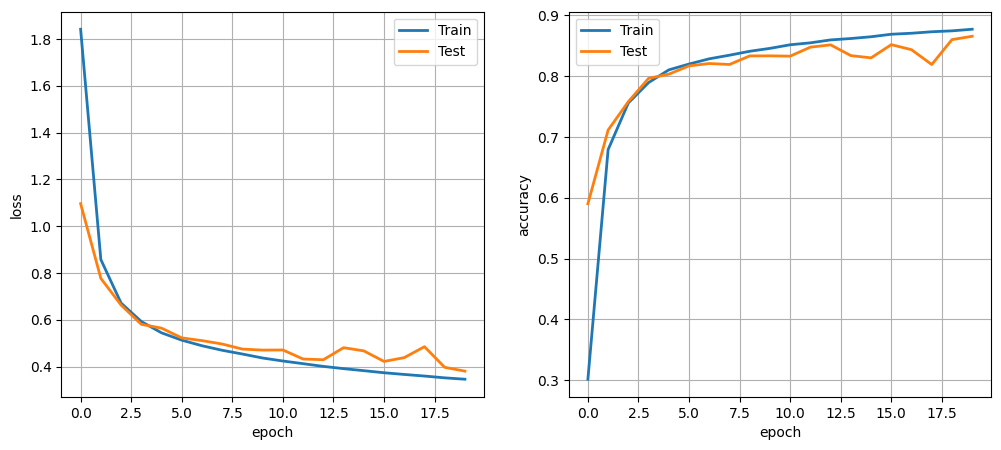

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(train_loss_history, '-', linewidth=2, label='Train')
axes[0].plot(test_loss_history, '-', linewidth=2, label='Test')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(train_accuracy_history, '-', linewidth=2, label='Train')
axes[1].plot(test_accuracy_history, '-', linewidth=2, label='Test')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].grid(True)
axes[1].legend()

plt.show()

In [18]:
import random

test_images = []
test_labels = []
random_indexes = [random.randrange(len(testdata)) for _ in range(3)]

for idx in random_indexes:
    image, label = testdata[idx]
    test_images.append(image)
    test_labels.append(label)
print(random_indexes)
print(test_labels)

[3924, 6362, 1861]
[0, 3, 0]


In [19]:
dense_model.eval()

test_images_inp = torch.stack(test_images, 0).cuda()
logits = dense_model(test_images_inp).cpu().detach()
probs = logits.softmax(dim=-1)
preds = probs.max(-1)[1]

print('Predicted:', preds.numpy())

Predicted: [0 3 6]


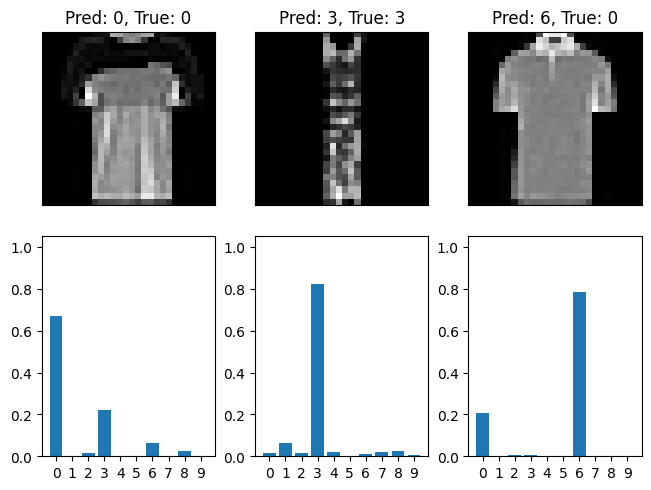

In [20]:
fig, axes = plt.subplots(2, 3, layout='constrained')

for i in range(3):
    axes[0, i].imshow(test_images[i].squeeze().cpu(), cmap=plt.cm.gray)
    axes[0, i].set_title(f'Pred: {preds[i]}, True: {test_labels[i]}')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    axes[1, i].bar(range(10), probs[i])
    axes[1, i].set_xticks(range(10))
    axes[1, i].set_ylim(0, 1.05)